In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
#from tensorflow.keras.layers import Input
#from tensorflow.keras.models import Model
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanSquaredError


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
def load_images(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img = cv2.imread(os.path.join(folder_path, filename))
            img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
            img = img[:,:,::-1]
            img_array = np.array(img) / 255.0
            image_list.append(img_array)
    return np.array(image_list)

folder_path = "/content/drive/My Drive/2023_spring/DS340/DS340_GroupProject/data/smd"
x_data = load_images(folder_path)

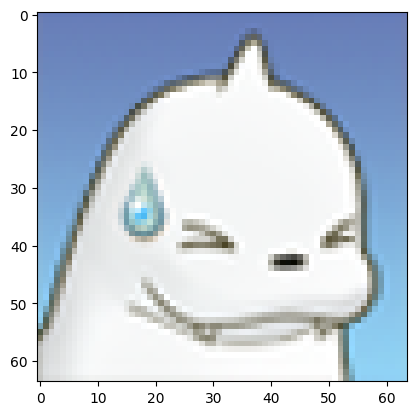

In [3]:
plt.imshow(x_data[0])

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda, Flatten
from tensorflow.keras.models import Sequential
import numpy as np

LATENT_DIM = 10  # Dimensionality of the latent space
IMAGE_SIZE = 64

# Encoder
encoder_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)

z_mean = Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = Dense(LATENT_DIM, name="z_log_var")(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(LATENT_DIM,), name="z")([z_mean, z_log_var])

encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# Decoder
decoder_input = Input(shape=(LATENT_DIM,))
x = Dense(512, activation="relu")(decoder_input)
x = Dense(8 * 8 * 256, activation="relu")(x)
x = Reshape((8, 8, 256))(x)
x = Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_output = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = Model(decoder_input, decoder_output, name="decoder")

# VAE
vae_output = decoder(encoder(encoder_input)[2])
vae = Model(encoder_input, vae_output, name="vae")

print(encoder.summary())
print(decoder.summary())
print(vae.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 128)    73856       ['conv2d_1[0][0]']               
                                                                                            

In [5]:
# Loss
reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(encoder_input, vae_output))
reconstruction_loss *= IMAGE_SIZE * IMAGE_SIZE
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

# Compile
vae.add_loss(vae_loss)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.97)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
vae.compile(optimizer = optimizer)

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

class PlotReconstructedImages(Callback):
    def __init__(self, x_val, interval=20):
        super().__init__()
        self.x_val = x_val
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            reconstructed_images = self.model.predict(self.x_val)
            self.plot_images(reconstructed_images)

    def plot_images(self, reconstructed_images):
        n = 10
        plt.figure(figsize=(20, 4))

        for i in range(n):
            # Display original images
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(self.x_val[i].reshape(IMAGE_SIZE, IMAGE_SIZE, 3), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # Display reconstructed images
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(reconstructed_images[i].reshape(IMAGE_SIZE, IMAGE_SIZE, 3), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.show()

plot_callback = PlotReconstructedImages(x_data, interval=20)

In [7]:
epochs = 500
batch_size = 256
vae.fit(x_data, x_data, epochs=epochs, batch_size=batch_size,callbacks=[plot_callback])

Output hidden; open in https://colab.research.google.com to view.

In [9]:
decoder.save('/content/drive/My Drive/2023_spring/DS340/DS340_GroupProject/decoder_model_April16.h5')

43/43 [==============================] - 0s 2ms/step


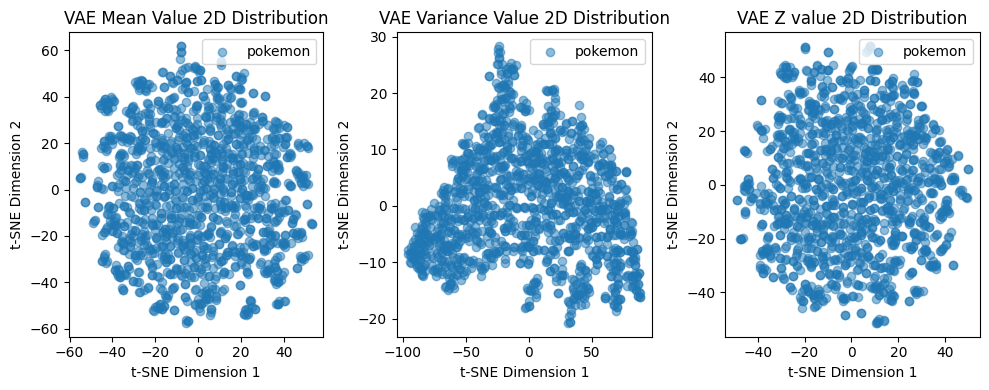

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

z_mean, z_log_var, z = encoder.predict(x_data)

# Perform t-SNE dimensionality reduction
z_mean_2d = TSNE(n_components=2).fit_transform(z_mean)
z_log_var_2d = TSNE(n_components=2).fit_transform(z_log_var)
z_2d = TSNE(n_components=2).fit_transform(z)

# Plot the 2D distribution of the latent space
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

axs[0].scatter(z_mean_2d[:, 0], z_mean_2d[:, 1], alpha=0.5, label = "pokemon")
axs[0].set_title("VAE Mean Value 2D Distribution")
axs[0].set_xlabel("t-SNE Dimension 1")
axs[0].set_ylabel("t-SNE Dimension 2")
axs[0].legend()

axs[1].scatter(z_log_var_2d[:, 0], z_log_var_2d[:, 1], alpha=0.5,  label = "pokemon")
axs[1].set_title("VAE Variance Value 2D Distribution")
axs[1].set_xlabel("t-SNE Dimension 1")
axs[1].set_ylabel("t-SNE Dimension 2")
axs[1].legend()

axs[2].scatter(z_2d[:, 0], z_2d[:, 1], alpha=0.5, label = "pokemon")
axs[2].set_title("VAE Z value 2D Distribution")
axs[2].set_xlabel("t-SNE Dimension 1")
axs[2].set_ylabel("t-SNE Dimension 2")
axs[2].legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 115ms/step


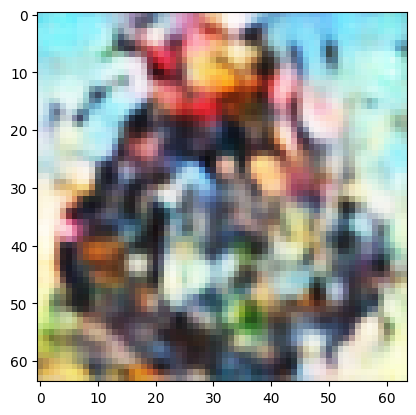

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the decoder model
decoder = load_model('/content/drive/My Drive/2023_spring/DS340/DS340_GroupProject/decoder_model_April16.h5')

# Sampling function
def sampling(z_mean, z_log_var):
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), dtype=tf.double)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Generate a random z_mean and z_log_var for demonstration
z_mean_example = np.random.normal(0, 1, (5, LATENT_DIM))
z_log_var_example = np.random.normal(0, 1, (5, LATENT_DIM))

# Obtain a sample from the latent space
z_sample = sampling(z_mean_example, z_log_var_example)

# Generate an image using the decoder
generated_image = decoder.predict(z_sample)

# Display the generated image
plt.imshow(generated_image[4])
plt.show()

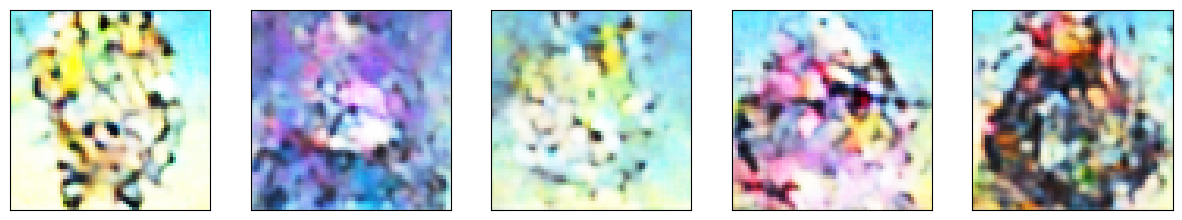

In [ ]:
n = 5

fig = plt.figure(figsize=(n * 3, 3))  # Set the figure size (optional)

for i in range(n):
    ax = plt.subplot(1, n, i + 1)  # Set 1 row and n columns
    plt.imshow(generated_image[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import InputLayer, Lambda, Dense

NOISE_DIM = 1

def sampling(args):
    z_mean, z_log_var = args
    print(z_mean.shape)
    print(z_log_var.shape)
    batch_size = tf.shape(z_mean)[0]
    epsilon = tf.keras.backend.random_normal(shape=(batch_size, LATENT_DIM))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def generator(decoder, noise_dim=NOISE_DIM):
    # Freeze layers in the saved model
    for i, layer in enumerate(decoder.layers):
        layer.trainable = False
        layer._name = f'saved_model_{i}_{layer.name}'

    model = Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        InputLayer(input_shape=(noise_dim,)),
        Dense(16, activation='relu'),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256 * 2),  # Output both z_mean_example and z_log_var_example
        Lambda(lambda x: sampling([x[:, :256], x[:, 256:]])),  # Apply the sampling function
    ])

    # Add layers from the saved model
    for layer in decoder.layers:
        model.add(layer)

    # Add additional layers if needed
    # model.add(tf.keras.layers.Dense(...))
    # model.add(tf.keras.layers.ReLU(...))

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return model

gen_model = generator(decoder)

(None, 256)
(None, 256)


(None, 256)
(None, 256)
1/1 [==============================] - 0s 203ms/step


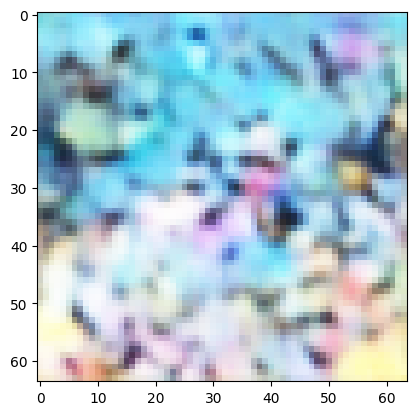

In [ ]:
noise_example = np.random.randn(1, NOISE_DIM)
output = gen_model.predict(noise_example)

plt.imshow(output[0])
plt.show()